# Simple Image Classification Using the MNIST Dataset
Nanyan "Rosalie" Zhu and Chen "Raphael" Liu

Some of the code in this notebook is inspired by [this GitHub repository](https://github.com/jkotra/mnist-pytorch).

### Import the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

import tensorflow.keras.datasets.mnist as MNIST

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings

### Set the random seed for reproducibility.

In [2]:
torch.manual_seed(4460)
np.random.seed(4460)

### Download the MNIST handwritten digits dataset.

It is designed to have a 60k-image train set and a 10k-image test set. We are not going to use all of them for this tutorial because that will eat up quite a bit of memory.

In [3]:
(image_MNIST_train_set, label_MNIST_train_set), (image_MNIST_test_set, label_MNIST_test_set) = MNIST.load_data()

#### Display some sample images and labels.

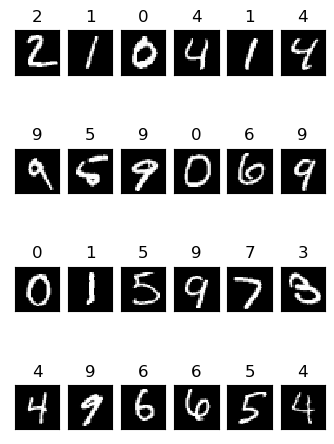

In [4]:
row = 4
col = 6
fig = plt.figure(figsize = (row, col), dpi = 100)

for image_index in range(1, row * col + 1):
    image = image_MNIST_test_set[image_index, :, :]
    ax = fig.add_subplot(row, col, image_index)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(str(label_MNIST_test_set[image_index]))
    plt.imshow(image, cmap = 'gray')

plt.show()

### We have 70k images in total, but we will only use a subset of it for this tutorial.

#### Let's just use what MNIST originally allocated as the test set as our entire dataset (N = 10k) and perform a 8:1:1 train:validation:test split.

In [5]:
# Split the 10000 MNIST test set into our train set (N = 8e3) and validation+test set (N = 2e3) at an 8:2 ratio.
indices_train, indices_validation_and_test = train_test_split(range(len(image_MNIST_test_set)), test_size = 0.2)
image_train = image_MNIST_test_set[indices_train, :, :]
label_train = label_MNIST_test_set[indices_train]
image_validation_and_test = image_MNIST_test_set[indices_validation_and_test, :, :]
label_validation_and_test = label_MNIST_test_set[indices_validation_and_test]

# Split the validation+test set into the validation set (N = 5e3) and the test set (N = 5e30).
# Note that we are using the package "train_test_split" but what we are actually doing here is validation test split.
indices_validation, indices_test = train_test_split(range(len(image_validation_and_test)), test_size = 0.5)
image_validation = image_validation_and_test[indices_validation, :, :]
label_validation = label_validation_and_test[indices_validation]
image_test = image_validation_and_test[indices_test, :, :]
label_test = label_validation_and_test[indices_test]

print('Images: train %d, validation %d, test %d \nLabels: train %d, validation %d, test %d' % \
      (len(image_train), len(image_validation), len(image_test), len(label_train), len(label_validation), len(label_test)))

Images: train 8000, validation 1000, test 1000 
Labels: train 8000, validation 1000, test 1000


### Reformat the images and labels so that they can be fed into the data loader.
Normally you would construct a validation loader and a test loader similar to how we construct the train loader, but for this case since the validation and test set only consists of 1000 28$\times$28 images each, we can just get away with not using a data loader at all.

In [6]:
image_train_torch = torch.from_numpy(image_train).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_train_torch = torch.from_numpy(label_train).type(torch.LongTensor)

image_validation_torch = torch.from_numpy(image_validation).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_validation_torch = torch.from_numpy(label_validation).type(torch.LongTensor)

image_test_torch = torch.from_numpy(image_test).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_test_torch = torch.from_numpy(label_test).type(torch.LongTensor)

train_data = TensorDataset(image_train_torch, label_train_torch)
train_loader = DataLoader(train_data, batch_size = 1000)

### Build our classification network.

This architecture comes from [this GitHub repository](https://github.com/floydhub/mnist).

<img src="data/MNIST_CNN.PNG" width="1200" align="center"/>

In [7]:
# Formula to calculate shape as we go through layer by layer = [(X - F + 2P)/S] + 1
# Here,
# X = Width / Height
# F = Kernel size
# P = Padding
# S = Strides (default = 1)

# Our input to the first layer is going to be [batchsize, 1, 28, 28]
# substitute, =[(28 - 5 + 2(0))/1] + 1
#             =[(23)/1] + 1
#             =23 + 1
#             =24


class Model(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

our_CNN = Model()

print(our_CNN)

Model(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


#### Define our optimizer.

In [8]:
# define our optimizer
optimizer = SGD(our_CNN.parameters(), lr = 0.001)

#### Train our CNN for classification.

In [9]:
EPOCHS = 30

train_epoch_loss = []
validation_epoch_loss = []

for epoch in range(EPOCHS):
    train_loss = []
    validation_loss = []

    for batch_index, (train_image, train_label) in enumerate(train_loader):
        #######################################################
        ####################### Train #########################
        #######################################################
        # Set the model to train mode so that the parameters can be updated.
        our_CNN.train()
        
        train_label_predicted = our_CNN(train_image)

        # compute the loss
        loss = F.cross_entropy(train_label_predicted, train_label)
        train_loss.append(loss.cpu().data.item())
        
        # reset the gradient
        optimizer.zero_grad()
        # backpropagate the loss
        loss.backward()
        # update the parameters
        optimizer.step()
        
        #######################################################
        ###################### Validation #####################
        #######################################################
        # Set the model to evaluation mode so that parameters are fixed.
        our_CNN.eval()
        
        validation_label_predicted = our_CNN(image_validation_torch)
        
        loss = F.cross_entropy(validation_label_predicted, label_validation_torch)
        validation_loss.append(loss.cpu().data.item())

    train_epoch_loss.append(np.mean(train_loss))
    validation_epoch_loss.append(np.mean(validation_loss))
    
    # save models
    torch.save(our_CNN.state_dict(), './saved_models/checkpoint_epoch_%s.pth' % (epoch))

    print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

Epoch: 0 | train_loss: 11.582892060279846 | validation_loss: 10.329494714736938
Epoch: 1 | train_loss: 1.8729448318481445 | validation_loss: 1.7434147745370865
Epoch: 2 | train_loss: 1.192696437239647 | validation_loss: 1.1732606142759323
Epoch: 3 | train_loss: 0.8540518656373024 | validation_loss: 0.8758899420499802
Epoch: 4 | train_loss: 0.6784760281443596 | validation_loss: 0.7100254967808723
Epoch: 5 | train_loss: 0.5733543634414673 | validation_loss: 0.6055929660797119
Epoch: 6 | train_loss: 0.5018570087850094 | validation_loss: 0.532720260322094
Epoch: 7 | train_loss: 0.45001640543341637 | validation_loss: 0.4797511287033558
Epoch: 8 | train_loss: 0.41040801256895065 | validation_loss: 0.43958277255296707
Epoch: 9 | train_loss: 0.37875260785222054 | validation_loss: 0.40775084123015404
Epoch: 10 | train_loss: 0.3526240661740303 | validation_loss: 0.3820585086941719
Epoch: 11 | train_loss: 0.3306576944887638 | validation_loss: 0.3606312908232212
Epoch: 12 | train_loss: 0.311942119

### Explanation on train, validation and test split.
While you are waiting for your CNN to be trained, let's look back on what it means to and why we need to perform a train/validation/test split.

- The train set is quite straightforward: you allocate a portion of the data to train your model.
- The test set is a set of data you keep to yourself and make sure the model doesn't have access to. You need that set of data to evaluate the performance of your model once it is ready to be challenged.
- The validation set is a set of data you quiz your model before it is ready for the "final exam" given by the test set. It gives you an idea how well the model is likely to perform on an unseen set of data.

In an ideal case, you design and train your model using the train data, adjust the hyperparameters (learning rate, etc.) and decide on when to stop the training (either by adjusting # epoch or by setting automated criteria for early stop) along with other intelligent approaches to make sure the model is likely to generalize well, and then test its performance on the test data.

#### Draw the train loss and validation loss curves.

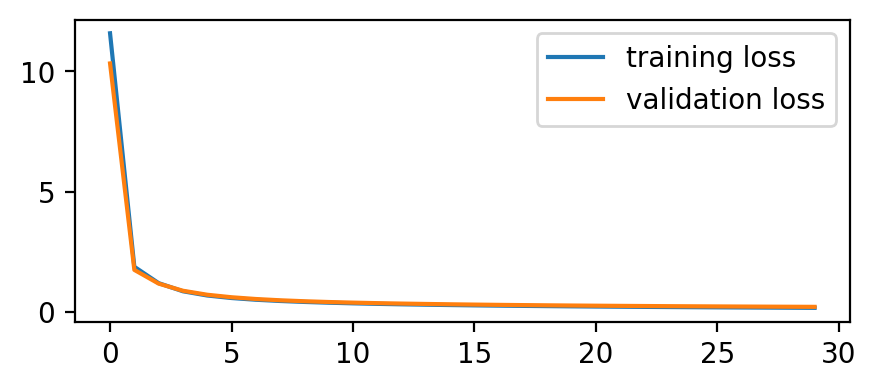

In [10]:
plt.figure(figsize = (5, 2), dpi = 200)
plt.plot(train_epoch_loss, label = 'training loss')
plt.plot(validation_epoch_loss, label = 'validation loss')
plt.legend(loc = 'upper right');

#### Let's check at which epoch the model performs the best on the validation set.

In [11]:
best_epoch = np.argmin(validation_epoch_loss)
print('best epoch: ', best_epoch)

best epoch:  29


#### We will call that as our best model and use that for inference on the test set.

In [12]:
state_dict = torch.load('./saved_models/checkpoint_epoch_%s.pth' % (best_epoch))
print(state_dict.keys())
our_CNN.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


<All keys matched successfully>

## Predict the labels on the test set.

### 1. Do that on a sample image.

In [13]:
def view_classify(image, probabilities, version = "MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize = (6, 9), ncols = 2)
    ax1.imshow(image.resize_(1, 28, 28).numpy().squeeze(), cmap = 'gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.bar(np.arange(10), probabilities)
    ax2.set_aspect(10)
    ax2.set_xticks(np.arange(10))
        
    ax2.set_title('Class Probability')
    ax2.set_ylim(0, 1.1)

    plt.tight_layout()

In [14]:
image_test_torch.shape

torch.Size([1000, 1, 28, 28])

In [15]:
our_CNN.eval()

sample_test_image = image_test_torch[0, :, :, :][np.newaxis, :, :, :]
sample_prediction = our_CNN(sample_test_image)

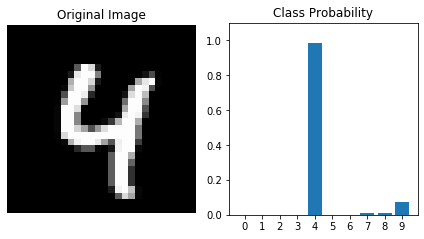

In [16]:
warnings.filterwarnings("ignore")
sns.reset_orig()
view_classify(sample_test_image, 2 ** sample_prediction)

### 2. This one is good, but what is the overall performance?

In [17]:
def predict_with_pytorch(model, input_data):
    model.eval()
    label_predicted_all = []

    label_predicted_one_hot = model(input_data)
    _, label_predicted_integer = torch.max(label_predicted_one_hot.data, 1)
    
    for current_prediction in label_predicted_integer:
        label_predicted_all.append(current_prediction.detach().cpu().numpy().item())

    return label_predicted_all    

In [18]:
test_label_predicted = predict_with_pytorch(our_CNN, image_test_torch)

accuracy = accuracy_score(label_test, test_label_predicted)

print("Accuracy:", accuracy * 100, "%")

Accuracy: 93.2 %


### 3. Lastly, can I have a more intuitive (and cooler) way to visualize the performance?

### Yes! The answer is a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)! 

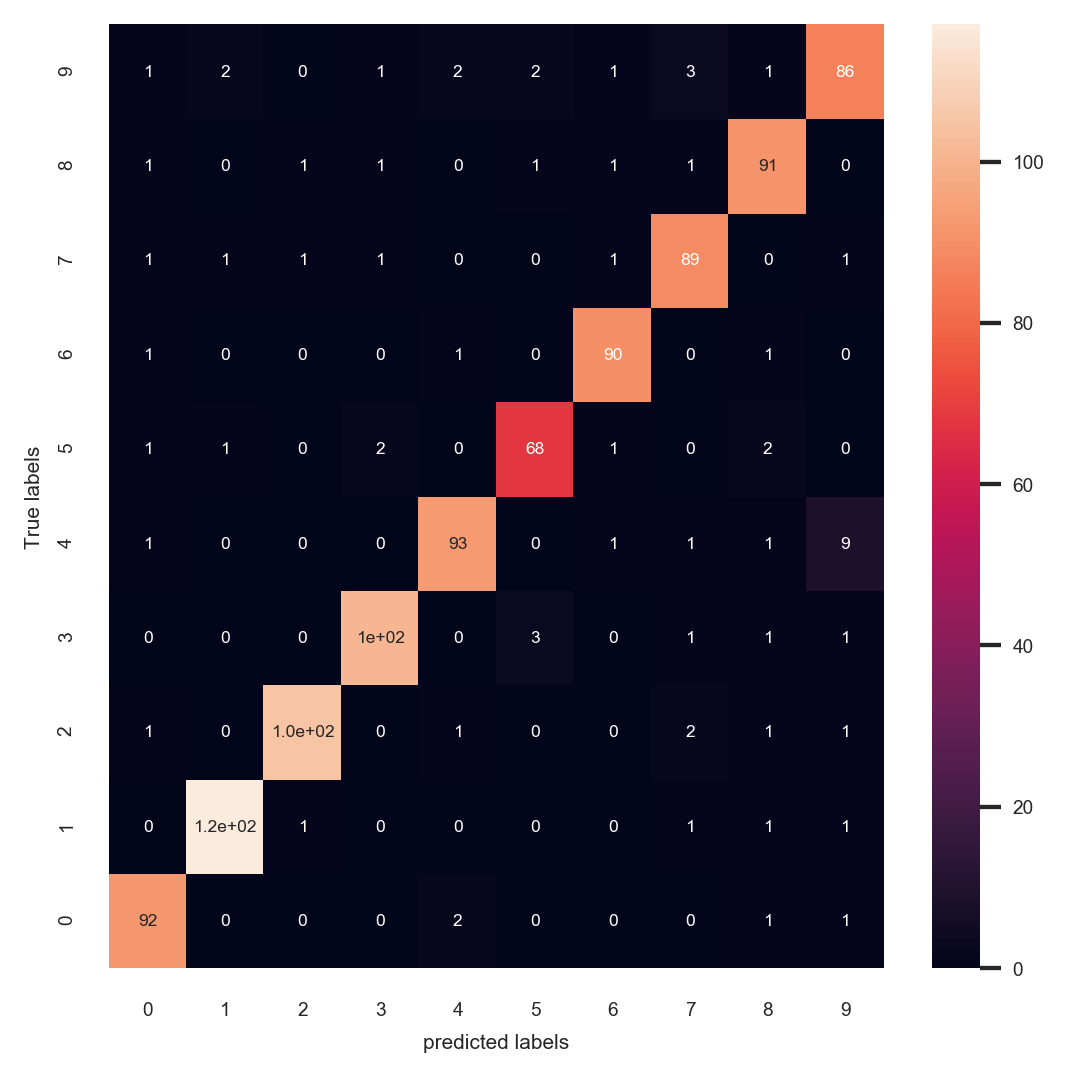

In [19]:
CM = confusion_matrix(label_test, test_label_predicted)

plt.figure(figsize = (5,5), dpi = 250)
sns.set(font_scale = 0.5)
sns.heatmap(CM, annot = True, annot_kws = {"size": 5})
plt.ylim([0, 10]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');